# Quantization

La quantization consiste à discrétiser les paramètres d'un réseau de neurones afin de réduire l'espace mémoire et les temps de calculer en contrepartie d'une perte de performance. Comment estimer ces paramètres pour minimiser la perte ?

## Une matrice de coefficients

On les prend d'un modèle de deep learning [MobileNet](https://github.com/onnx/models/tree/main/vision/classification/mobilenet).

In [15]:
import os
import urllib
import urllib.request

url = "https://github.com/onnx/models/raw/refs/heads/main/validated/vision/classification/mobilenet/model/mobilenetv2-12.onnx"
destination = "mobilenetv2-12.onnx"

if not os.path.exists(destination) or os.stat(destination).st_size < 10000:
    print(f"download {destination!r}")
    g = urllib.request.urlopen(url)
    with open(destination, "wb") as f:
        f.write(g.read())
    print("done")
else:
    print(f"already downloaded {destination!r}")
print(f"model size {os.stat(destination).st_size} bytes")

already downloaded 'mobilenetv2-12.onnx'
model size 13964571 bytes


In [16]:
from onnx import load

with open(destination, "rb") as f:
    onx = load(f)
    print(f"model size: {len(onx.SerializeToString())}")

model size: 13964571


On prend une des plus grandes matrices de coefficients.

In [17]:
initializers = []
for init in onx.graph.initializer:
    initializers.append((len(init.SerializeToString()), init.name, init))

initializers.sort()

for init in initializers[-5:]:
    print(init[:2])

(614421, '616')
(614421, '619')
(1228821, '625')
(1638421, '628')
(5120034, 'classifier.1.weight')


In [18]:
from onnx.numpy_helper import to_array

coef = to_array(initializers[-4][-1])
coef.shape, coef.dtype

((960, 160, 1, 1), dtype('float32'))

## Distributions

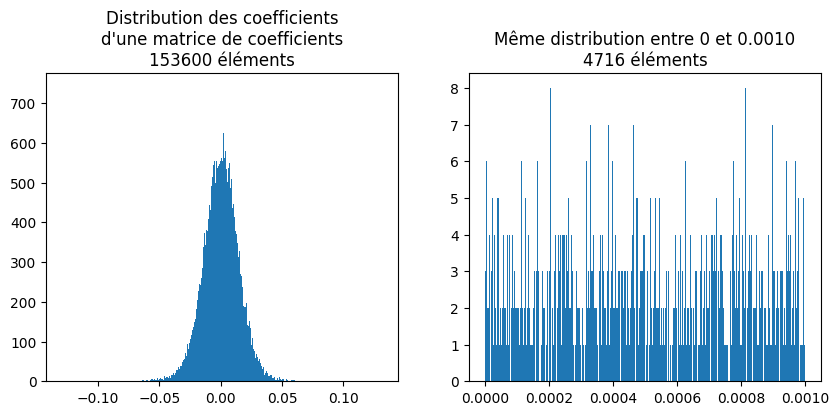

In [19]:
import matplotlib.pyplot as plt

cf = coef.ravel()
cf01 = cf[(cf >= 0) & (cf <= 0.001)]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(cf, bins=2048)
axs[0].set_title(
    f"Distribution des coefficients\nd'une matrice de coefficients\n{cf.size} éléments"
)
axs[1].hist(cf01, bins=2048)
title = f"Même distribution entre 0 et {cf01.max():.4f}\n{cf01.size} éléments"
axs[1].set_title(title);

Et maintenant la distribution des float 8.

In [20]:
import numpy
from onnx.numpy_helper import float8e4m3_to_float32

float8 = [float8e4m3_to_float32(i) for i in range(256)]
no_nan8 = [f for f in float8 if not numpy.isnan(f)]
len(no_nan8)

254

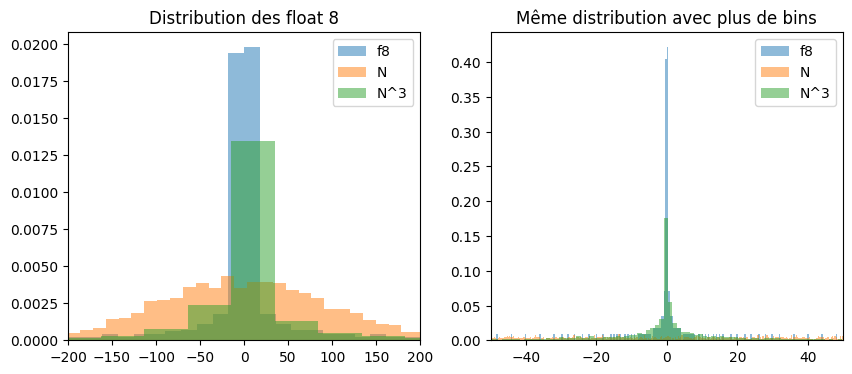

In [21]:
p = 3
gauss = numpy.random.normal(size=len(no_nan8) * 20)
scale1 = numpy.std(no_nan8) / numpy.std(gauss)
scalep = numpy.std(no_nan8) / numpy.std(gauss**p)


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(float8, bins=50, alpha=0.5, label="f8", density=True)
axs[0].hist(gauss * scale1, bins=50, alpha=0.5, label="N", density=True)
axs[0].hist(gauss**p * scalep, bins=50, alpha=0.5, label=f"N^{p}", density=True)
axs[0].set_xlim([-200, 200])
axs[0].set_title("Distribution des float 8")
axs[0].legend()

axs[1].hist(float8, bins=2000, alpha=0.5, label="f8", density=True)
axs[1].hist(gauss * scale1, bins=2000, alpha=0.5, label="N", density=True)
axs[1].hist(gauss**p * scalep, bins=2000, alpha=0.5, label=f"N^{p}", density=True)
axs[1].set_xlim([-50, 50])
axs[1].set_title("Même distribution avec plus de bins")
axs[1].legend();

Les coefficients ont l'air distribués selon une loi gaussienne. Les float 8 un peu plus selon une loi gaussienne à la puissance 3. On se sert de cette observations pour estimer le paramètre $\lambda$. Néanmoins, la normalisation choisie ne permet que de changer d'échelle.

## Estimation de l'échelle

On veut également comparer avec une quantization classique avec des entiers sur 8 bits.

In [22]:
from onnx import TensorProto


def estimation_quantization_scale(
    coef: numpy.array,
    to: int = TensorProto.FLOAT8E4M3FN,
    method: str = "naive",
    threshold: float = 0.99999,
) -> tuple[float, float]:
    """
    Estimates the scale parameter for the quantization to float 8 assuming
    the distribution of the coefficients is gaussian.
    """
    if to == TensorProto.FLOAT8E4M3FN:
        float8 = [float8e4m3_to_float32(i) for i in range(256)]
        quant_float = [f for f in float8 if not numpy.isnan(f)]
        if method == "naive":
            std_coef = numpy.std(coef.ravel())
            std_quant = numpy.std(numpy.array(quant_float, dtype=numpy.float32))
        elif method == "power":
            cr = coef.ravel()
            ca = numpy.abs(cr)
            std_coef = numpy.std(ca ** (1.0 / 3.0) * cr / ca)
            std_quant = numpy.std(numpy.array(quant_float, dtype=numpy.float32))
        else:
            raise ValueError(f"Unexpected quantization method {method!r}.")
        zero = 0.0
        scale = std_quant / std_coef
    elif to == TensorProto.UINT8:
        qu = numpy.quantile(coef.ravel(), [1 - threshold, threshold])
        scale = 255 / (qu[1] - qu[0])
        zero = qu[0] * scale
    else:
        raise ValueError(f"Unexpected quantization type for to={to}.")

    return 1.0 / scale, -zero


scale_f8, zero_f8 = estimation_quantization_scale(coef)
scale_f8, zero_f8

(np.float32(0.00014669707), -0.0)

In [23]:
scale_f8p, zero_f8p = estimation_quantization_scale(coef, method="power")
scale_f8p, zero_f8p

(np.float32(0.002160199), -0.0)

In [24]:
scale_u8, zero_u8 = estimation_quantization_scale(coef, to=TensorProto.UINT8)
scale_u8, zero_u8

(np.float64(0.0007863875484906944), np.float64(123.14246096563787))

Vérification par un graphique

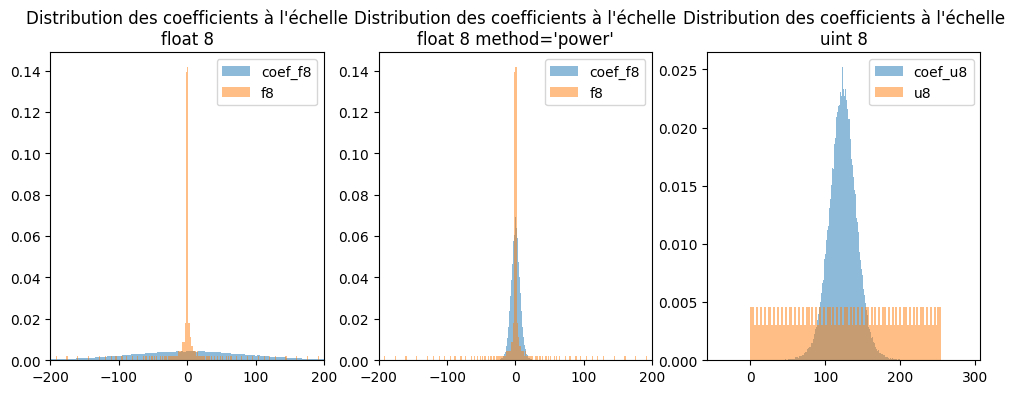

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(coef.ravel() / scale_f8, bins=512, density=True, label="coef_f8", alpha=0.5)
axs[0].hist(no_nan8, bins=512, alpha=0.5, label="f8", density=True)
axs[0].legend()
axs[0].set_xlim([-200, 200])
axs[0].set_title("Distribution des coefficients à l'échelle\nfloat 8")

axs[1].hist(
    coef.ravel() / scale_f8p, bins=512, density=True, label="coef_f8", alpha=0.5
)
axs[1].hist(no_nan8, bins=512, alpha=0.5, label="f8", density=True)
axs[1].legend()
axs[1].set_xlim([-200, 200])
axs[1].set_title("Distribution des coefficients à l'échelle\nfloat 8 method='power'")

axs[2].hist(
    coef.ravel() / scale_u8 + zero_u8,
    bins=512,
    density=True,
    label="coef_u8",
    alpha=0.5,
)
axs[2].hist(list(range(256)), bins=100, alpha=0.5, label="u8", density=True)
axs[2].legend()
axs[2].set_title("Distribution des coefficients à l'échelle\nuint 8");

Pas évident de choisir les bons paramètres.

## QDQ

On compare la perte avec deux opérations [QuantizeLinear](https://onnx.ai/onnx/operators/onnx__QuantizeLinear.html) + [DequantizeLinear](https://onnx.ai/onnx/operators/onnx__DequantizeLinear.html).

In [26]:
from onnx.helper import (
    make_node,
    make_graph,
    make_model,
    make_tensor_value_info,
    make_operatorsetid,
    make_tensor,
)
from onnx.reference import ReferenceEvaluator

X = make_tensor_value_info("X", TensorProto.FLOAT, [None])
Scale = make_tensor_value_info("Scale", TensorProto.FLOAT, [1])
Y = make_tensor_value_info("Y", TensorProto.FLOAT, [None])

model_f8 = make_model(
    make_graph(
        [
            make_node(
                "Constant",
                [],
                ["Zero"],
                value=make_tensor("Zero", TensorProto.FLOAT8E4M3FN, [1], [0.0]),
            ),
            make_node("QuantizeLinear", ["X", "Scale", "Zero"], ["Q"], axis=0),
            make_node("DequantizeLinear", ["Q", "Scale"], ["Y"], axis=0),
        ],
        "quf8",
        [X, Scale],
        [Y],
    ),
    opset_imports=[make_operatorsetid("", 19)],
)

ref_f8 = ReferenceEvaluator(model_f8)
qu_f8 = ref_f8.run(
    None, {"X": coef.ravel(), "Scale": numpy.array([scale_f8], dtype=numpy.float32)}
)[0]
qu_f8

array([-0.00821504,  0.00381412, -0.00010085, ...,  0.00880182,
       -0.02112438, -0.00410752], dtype=float32)

In [27]:
qu_f8p = ref_f8.run(
    None, {"X": coef.ravel(), "Scale": numpy.array([scale_f8p], dtype=numpy.float32)}
)[0]
qu_f8p

array([-0.0086408 ,  0.00378035, -0.00010126, ...,  0.0086408 ,
       -0.02160199, -0.0043204 ], dtype=float32)

In [28]:
model_u8 = make_model(
    make_graph(
        [
            make_node(
                "Constant",
                [],
                ["Zero"],
                value=make_tensor("Zero", TensorProto.UINT8, [1], [int(zero_u8)]),
            ),
            make_node("QuantizeLinear", ["X", "Scale", "Zero"], ["Q"], axis=0),
            make_node("DequantizeLinear", ["Q", "Scale", "Zero"], ["Y"], axis=0),
        ],
        "quu8",
        [X, Scale],
        [Y],
    ),
    opset_imports=[make_operatorsetid("", 19)],
)

ref_u8 = ReferenceEvaluator(model_u8)
qu_u8 = ref_u8.run(
    None, {"X": coef.ravel(), "Scale": numpy.array([scale_u8], dtype=numpy.float32)}
)[0]
qu_u8

array([-0.00865026,  0.00393194,  0.        , ...,  0.00865026,
       -0.02123246, -0.00393194], dtype=float32)

In [29]:
err_f8 = ((coef.ravel() - qu_f8) ** 2).sum() ** 0.5
err_f8p = ((coef.ravel() - qu_f8p) ** 2).sum() ** 0.5
err_u8 = ((coef.ravel() - qu_u8) ** 2).sum() ** 0.5
err_f8, err_f8p, err_u8

(np.float32(0.21044867), np.float32(0.15230674), np.float32(0.09929135))

La quantization avec les float 8 fonctionne moins bien que la quantization avec des entiers.

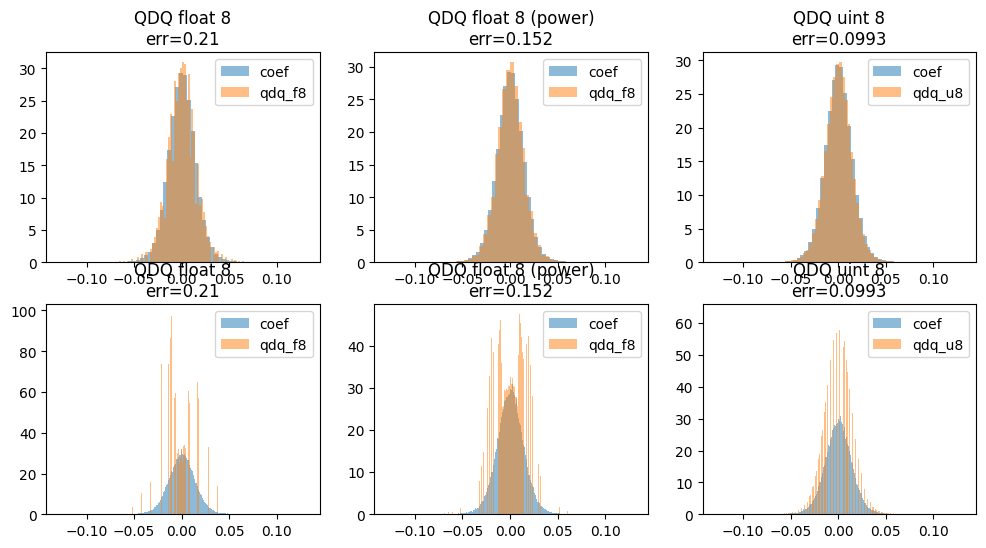

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for i, bins in [(0, 64), (1, 512)]:
    axs[i, 0].hist(coef.ravel(), bins=bins, density=True, label="coef", alpha=0.5)
    axs[i, 0].hist(qu_f8, bins=bins, alpha=0.5, label="qdq_f8", density=True)
    axs[i, 0].legend()
    axs[i, 0].set_title(f"QDQ float 8\nerr={err_f8:1.3g}")

    axs[i, 1].hist(coef.ravel(), bins=bins, density=True, label="coef", alpha=0.5)
    axs[i, 1].hist(qu_f8p, bins=bins, alpha=0.5, label="qdq_f8", density=True)
    axs[i, 1].legend()
    axs[i, 1].set_title(f"QDQ float 8 (power)\nerr={err_f8p:1.3g}")

    axs[i, 2].hist(coef.ravel(), bins=bins, density=True, label="coef", alpha=0.5)
    axs[i, 2].hist(qu_u8, bins=bins, alpha=0.5, label="qdq_u8", density=True)
    axs[i, 2].legend()
    axs[i, 2].set_title(f"QDQ uint 8\nerr={err_u8:1.3g}")

## Et avec plusieurs valeurs d'échelle

In [31]:
from pandas import DataFrame
from tqdm import tqdm

a = 0.00014669707383747942
h = 0.00014669707383747942 * 2

data = []
for scale in tqdm([a + h * i for i in range(5)]):
    got = ref_f8.run(
        None, {"X": coef.ravel(), "Scale": numpy.array([scale], dtype=numpy.float32)}
    )[0]
    err = ((coef.ravel() - got) ** 2).sum() ** 0.5
    obs = dict(scale=scale, err=err, scale_f8p=scale_f8p, scale_f8=scale_f8)
    data.append(obs)

df = DataFrame(data)
df

100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


,scale,err,scale_f8p,scale_f8
0,0.000147,0.210449,0.00216,0.000147
1,0.000440,0.152721,0.00216,0.000147
2,0.000733,0.152714,0.00216,0.000147
3,0.001027,0.151731,0.00216,0.000147
4,0.001320,0.152831,0.00216,0.000147


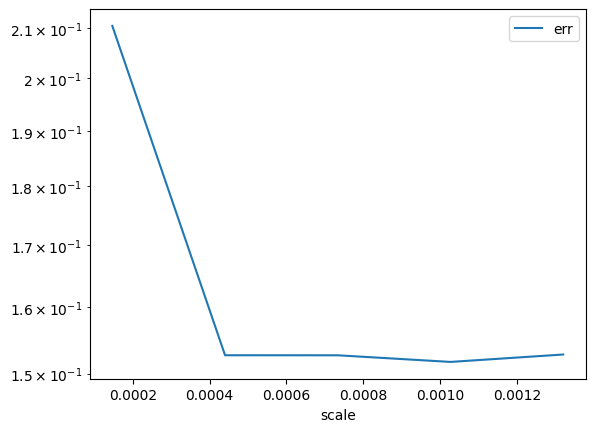

In [32]:
df.plot(x="scale", y="err", logy=True);

Pas mieux.

## Optimisation